# Model kentang tanpa transfer learning

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

2023-05-19 09:47:37.803723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D
from keras.optimizers import Adam, RMSprop


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

Num GPUs Available:  1


In [4]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Split train test 
import splitfolders 
splitfolders.ratio("Kentang", output="Kentang-data", seed=1337, ratio=(.8, .2), group_prefix=None) 

In [6]:
training_dir = os.path.join('/tf/disk/Kentang-data/', 'train')
testing_dir = os.path.join('/tf/disk/Kentang-data/', 'val')

In [7]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	training_dir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	testing_dir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)

Found 1874 images belonging to 3 classes.
Found 471 images belonging to 3 classes.


In [24]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)

{'Potato__early_blight': 0, 'Potato__healthy': 1, 'Potato__late_blight': 2}
['Potato__early_blight', 'Potato__healthy', 'Potato__late_blight']


In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

In [30]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [31]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [32]:
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    callbacks=[myCallback()], 
                    validation_steps=3)

Epoch 1/50


2023-05-19 10:03:49.779985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - ETA: 0s - loss: 0.9737 - accuracy: 0.4797

2023-05-19 10:04:38.834223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - 52s 856ms/step - loss: 0.9737 - accuracy: 0.4797 - val_loss: 0.9058 - val_accuracy: 0.5625
Epoch 2/50
59/59 [==============================] - 12s 212ms/step - loss: 0.8652 - accuracy: 0.5939 - val_loss: 0.7557 - val_accuracy: 0.7188
Epoch 3/50
59/59 [==============================] - 12s 203ms/step - loss: 0.7420 - accuracy: 0.6836 - val_loss: 0.5168 - val_accuracy: 0.7396
Epoch 4/50
59/59 [==============================] - 11s 189ms/step - loss: 0.6339 - accuracy: 0.7428 - val_loss: 0.5793 - val_accuracy: 0.6979
Epoch 5/50
59/59 [==============================] - 11s 183ms/step - loss: 0.5625 - accuracy: 0.7631 - val_loss: 1.0375 - val_accuracy: 0.6042
Epoch 6/50
59/59 [==============================] - 12s 196ms/step - loss: 0.5024 - accuracy: 0.7850 - val_loss: 0.6203 - val_accuracy: 0.7396
Epoch 7/50
59/59 [==============================] - 11s 183ms/step - loss: 0.4571 - accuracy: 0.8079 - val_loss: 1.0253 - val_accuracy: 0.6875
Epoch 8/50

In [33]:
model.save_weights('kentangModel2.h5')
print('Model Saved!')
 
# load model
# savedModel = model.load_weights('kentangModelEarly.h5')
# print('Model Loaded!')

Model Saved!


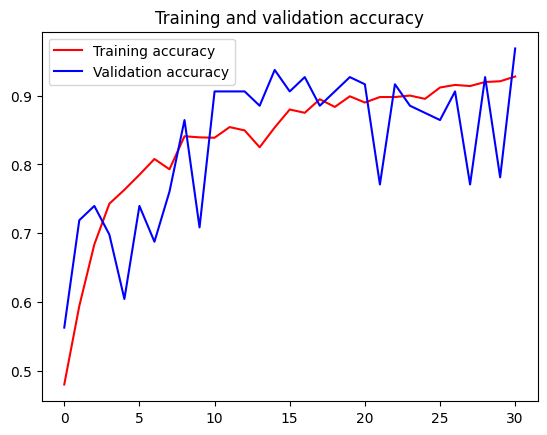

<Figure size 640x480 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()


In [35]:
Potato__early_blight = ''
Potato__early_blight = "https://cropscience.bayer.co.uk/media/103035203/early-blight.png?preset=384_x_230"
Potato__early_blight = tf.keras.utils.get_file('Potato__early_blight', origin=Potato__early_blight)

img = tf.keras.utils.load_img(
    Potato__early_blight, target_size=(150, 150)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 135ms/step
This image most likely belongs to Potato__early_blight with a 57.61 percent confidence.
